seed: 0
epochs: 1, steps_per_epoch: 1, crop_size: 16, mlr: 0.8
DEBUG: device forced: cuda


100%|████████████████████████████████| 1/1 [00:00<00:00,  1.97it/s, epoch loss (batch)=1.14, loss slice=1.14, validation (batch)=0.837]

train loss:[0.421674058331891, 12.449656773208366, 7.926590208064376, 3.5784844481975204, 0.8645102218594511, 2.6263041715276376, 1.1785612725531327, 1.7056979704199704, 1.279687271160736, 1.390245084062019, 1.1416403273809048],
validation loss: [0.2161769830316072, 3.671984622791482, 1.5420270561466252, 0.5115853346590915, 0.7703601515369631, 0.4419794165508514, 1.0900514202201608, 0.43949397162553594, 0.42136413977532705, 0.4219397759741743, 0.8369117294340176]


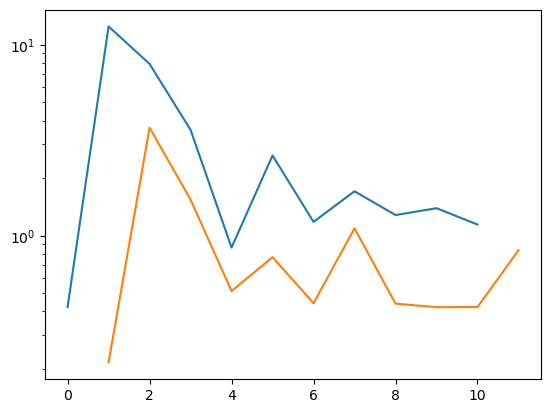

In [89]:
from scipy.interpolate import CubicSpline
from glob import glob
import utils.training as ut
from os import makedirs as mkdir
import argparse

from torch.utils.data import random_split, DataLoader
import os
import numpy as np
import torch
from utils.visualisation.visual_utils import *

from utils.model import Unet
from utils.data_loading import DnsTemperatureLoaderCoarse
from utils.transforms import (get_transforms_no_y_sampling,
                              get_transforms_no_depth_flip,
                              get_transforms_and_coord)

from utils.loss import loss_grad_rms
from utils.data_loading import middle_point
from utils.training import RMSELoss
from tqdm import tqdm
from gc import collect
from torch import nn
collect()
try:
    torch.cuda.empty_cache()
except:
    pass


def mean_txz(x):
    return torch.mean(x, (0, -2, -3))
def rms(x):
    return torch.sqrt(mean_txz(x**2)-mean_txz(x)**2)
def loss(x, y):
    return torch.sqrt(nn.MSELoss()(x, y))



def dtdy_torch(T, coord_les):
    k = np.arange(0, T.shape[-1] - 1)
    _, _, z = coord_les
    z = torch.tensor(z)
    dtdy = torch.zeros([*T.shape[:-1], T.shape[-1] + 1])
    dtdy[..., 1:-1] = (T[..., k+1] - T[..., k])/(z[k+1] - z[k])
    d1, d2 = z[1] - z[0], z[2] - z[0]
    d12 = z[2] - z[1]
    dtdy[..., 0] = - d1*d2/d12 * (T[..., 2] / (d2**2) - T[..., 1] / (
        d1**2) - T[..., 0] * ((d1**2 - d2**2)/((d1**2) * (d2**2))))
    dtdy[..., -1] = d1*d2/d12 * (T[..., -3] / (d2**2) - T[..., -2] / (
        d1**2) - T[..., -1] * ((d1**2 - d2**2)/((d1**2) * (d2**2))))
    return dtdy
dtdy=dtdy_torch


def loss_grad_rms(x, y, coord_elem, coord_face, cmax=0.029806747737097676, fmax=0.02984599955379963):
    # MSE on mean quantities
    coord_elem[-1] = coord_elem[-1]/cmax
    coord_face[-1] = coord_face[-1]/fmax

    cf = [None, None, coord_face[-1][1:-1]]
    ce = [None, None, coord_elem[-1][1:-1]]

    
    norm_dns = torch.norm(mean_txz(x))
    norm_rms = torch.norm(rms(x))

    mean_quantities = loss(mean_txz(x), mean_txz(y))/norm_dns
    rms_quantities = loss(rms(x), rms(y))/norm_rms

    # MSE on wall-normal gradient quantities
    gx, gy = dtdy(x, coord_elem)[..., 1:-1], dtdy(y, coord_elem)[..., 1:-1]
    # GX.shape = (n, 1, 16, 16, 15)
    norm_gradient = torch.norm(mean_txz(gx))
    norm_gradient_rms = torch.norm(rms(gx))

    mean_gradient_quantities = loss(mean_txz(gx), mean_txz(gy))/norm_gradient
    rms_gradient_quantities = loss(rms(gx), rms(gy))/norm_gradient_rms

    g2x, g2y = d2tdy2(x[..., 1:-1], gx, cf)[..., 1:-1], d2tdy2(y[..., 1:-1], gy, cf)[..., 1:-1]
    # G2X.shape = (n, 1, 16, 16, )
    norm_gradient_gradient = torch.norm(g2x)
    norm_gradient_gradient_rms = torch.norm(rms(g2x))
    mean_gradient_gradient_quantities = loss(mean_txz(g2x), mean_txz(g2y))/norm_gradient_gradient
    rms_gradient_gradient_quantities = loss(rms(g2x), rms(g2y))/norm_gradient_gradient_rms

    return mean_quantities + rms_quantities +\
        mean_gradient_quantities + rms_gradient_quantities +\
        mean_gradient_gradient_quantities + rms_gradient_gradient_quantities

def loss_grad_torch(x, y, coord_elem, coord_face, cmax=0.029806747737097676, fmax=0.02984599955379963):
    coord_elem[-1] = coord_elem[-1]/cmax
    coord_face[-1] = coord_face[-1]/fmax

    ce = [None, None, coord_elem[-1][1:-1]]
    norm_dns = torch.norm(mean_txz(x))
    norm_rms = torch.norm(rms(x))

    mean_quantities = loss(mean_txz(x), mean_txz(y))/norm_dns
    rms_quantities = loss(rms(x), rms(y))/norm_rms

    # MSE on wall-normal gradient quantities
    gx, gy = torch.gradient(x, spacing=(coord_elem[-1],), dim=-1)[0][..., 1:-1], torch.gradient(y, spacing=(coord_elem[-1],), dim=-1)[0][..., 1:-1]
    # GX.shape = (n, 1, 16, 16, 15)
    norm_gradient = torch.norm(mean_txz(gx))
    norm_gradient_rms = torch.norm(rms(gx))

    mean_gradient_quantities = loss(mean_txz(gx), mean_txz(gy))/norm_gradient
    rms_gradient_quantities = loss(rms(gx), rms(gy))/norm_gradient_rms

    g2x, g2y = torch.gradient(x, spacing=(coord_elem[-1],), dim=-1)[0][..., 1:-1], torch.gradient(y, spacing=(coord_elem[-1],), dim=-1)[0][..., 1:-1]
    # G2X.shape = (n, 1, 16, 16, )
    norm_gradient_gradient = torch.norm(g2x)
    norm_gradient_gradient_rms = torch.norm(rms(g2x))
    mean_gradient_gradient_quantities = loss(mean_txz(g2x), mean_txz(g2y))/norm_gradient_gradient
    rms_gradient_gradient_quantities = loss(rms(g2x), rms(g2y))/norm_gradient_gradient_rms

    return mean_quantities + rms_quantities +\
        mean_gradient_quantities + rms_gradient_quantities +\
        mean_gradient_gradient_quantities + rms_gradient_gradient_quantities


def d2tdy2(T, dtdy, coord_les):
    _, _, z = coord_les
    k = np.arange(T.shape[-1])
    out = (dtdy[..., k+1] - dtdy[..., k])/(z[k+1] - z[k])
    return out




@torch.no_grad()
def fast_evaluate_gradients(
    net, batch, device, criterion, coord_elem, coord_face
):
    """
    Validation loop
    """
    validation_loss = 0
    net.to(device)
    for dns, les in batch:
        # move images and labels to correct device and type
        dns = dns.to(device)
        les = les.to(device)
        coord_elem = coord_elem.to(device)
        coord_face = coord_face.to(device)
        # print(dns.min(), les.min())
        # print(dns.max(), les.max())
        prediction = net(les) + les
        validation_loss += criterion(dns, prediction, [None, None, coord_elem], [None, None, coord_face]).item()
    net.train()
    return validation_loss



def curriculum_learning_growing_domain_gradients(
    train_loader, val_loader, coord_elem, coord_face, net, lr, scheduler, steps_per_epoch, transforms,
    device, criterion=RMSELoss, epochs=150, crop_size=16, mlr=.8, save=True,
    additional_save_string="", debug=False
):
    """
    Curriculum learning function
    """
    print(f"epochs: {epochs}, steps_per_epoch: {steps_per_epoch}, crop_size: {crop_size}, mlr: {mlr}")
    train_loss = []
    validation_loss = []
    batch = torch.tensor([0])
    val = torch.tensor([0])
    if debug:
        device="cuda"
        print(f"DEBUG: device forced: {device}")
        net.to(device)
    for batch in train_loader:
        batch = tuple(batch)
        break
    for val in val_loader:
        val = tuple(val)
        break
    # print(batch[0].shape, batch[1].shape)
    slices = np.arange(crop_size, batch[0].size(-1)+4, 4)
    n_train = batch[0].size(0)
    
    additional_examples = np.ceil(((slices)/crop_size - 1) * n_train).astype(dtype=int)

    optim = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim, lr_lambda=lambda epoch: mlr)
    
    coord_elem, coord_face = torch.from_numpy(coord_elem), torch.from_numpy(coord_face)
    
    
    # First untrained inference
    dns, les = batch
    batch_ = tuple((dns[:, ..., :slices[0]],
                   les[:, ..., :slices[0]]))
    val_dns, val_les = val
    val_ = tuple((val_dns[..., :slices[0]],
                 val_les[..., :slices[0]]))
    c_ = coord_elem[:slices[0]]
    f_ = coord_face[:slices[0]+1]

    with torch.no_grad():
        net.eval()
        eval_net = net.cpu()
        dns, les = batch_
        dns = dns.to("cpu")
        les = les.to("cpu")
        c, f = c_.to("cpu"), f_.to("cpu")

    dns_recon = les + eval_net(les)
    tl = criterion(dns, dns_recon, [None, None,c], [None, None, f])
    del dns, dns_recon, les
    vl = 0
    vl = vl + fast_evaluate_gradients(net, val_loader, device, criterion, coord_elem, coord_face)  / len(val_loader)
    train_loss.append(tl.item())
    validation_loss.append(vl)    
    for add, subdomain_slice in zip(additional_examples, slices):
        additional_choises = np.random.choice(n_train, add)
        indexes = np.concatenate([np.arange(n_train), additional_choises])
        dns, les = batch
        val_dns, val_les = val
        batch_ = tuple((dns[indexes, ..., :subdomain_slice],
                       les[indexes, ..., :subdomain_slice]))
        val_ = tuple((val_dns[..., :subdomain_slice],
                     val_les[..., :subdomain_slice]))
        c_ = coord_elem[:subdomain_slice]
        f_ = coord_face[:subdomain_slice+1]
        transforms = get_transforms_and_coord(crop=True, flip=True, rotate=True, crop_size=16, flip_prob=1/3., coord_elem=c_, coord_face=f_, n_rot=4)
        with tqdm(range(1, epochs+1)) as pbar:
            for epoch in pbar:
                global_step = 0
                net.train()
                epoch_loss = 0
                for step in range(steps_per_epoch):
                    optim.zero_grad()
                    dns, les, c, f = transforms(tuple(batch_))
                    # print(c.shape, f.shape)
                    dns = dns.to(device)
                    les = les.to(device)
                    c, f = c.to(device), f.to(device)
                    # print(dns.min(), les.min())
                    # print(dns.max(), les.max())
                    # a = transforms(tuple((batch_)))

                    dns_recon = les + net(les)
                    loss = criterion(dns, dns_recon, [None, None,c], [None, None, f])
                    del dns, dns_recon, les
                    loss.backward()

                    optim.step()

                    global_step += 1
                    epoch_loss += loss.item()
                    
                # with torch.no_grad():
                #     if debug:
                #         device="cpu"
                #     net.eval()
                #     eval_net = net.to(device)
                #     dns, les = batch_
                #     dns = dns.to(device)
                #     les = les.to(device)
                #     c, f = c_.to(device), f_.to(device)
                #     dns_recon = les + eval_net(les)
                #     tl = criterion(dns, dns_recon, [None, None,c], [None, None, f])
                #     del dns, dns_recon, les
                tl = epoch_loss / steps_per_epoch
                vl = 0
                vl = vl + fast_evaluate_gradients(net, val_loader, device, criterion, coord_elem, coord_face)  / len(val_loader)

                pbar.set_postfix(**{'loss slice': tl, 'epoch loss (batch)': epoch_loss/steps_per_epoch,
                                 'validation (batch)': vl})
                if epoch % 10 == 0:
                    scheduler.step()
                # return train_loss, valid_loss, net
                train_loss.append(tl)
                validation_loss.append(vl)

        optim = torch.optim.Adam(net.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(
            optim, lr_lambda=lambda epoch: mlr)
    return train_loss, validation_loss, net




def train_on_statistics_only(
    epochs=5, steps_per_epoch=1, save=True, reproducibility=True,
    seed=0
):
    # device = "cuda"
    device = "cuda" if torch.cuda.is_available() else "cpu"
    import socket
    if socket.gethostname() == "compta68":
        images_dir = "/home/zatout/Documents/These_yanis/Reunion_10012022/"
        path = "/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/"

    else:
        images_dir = "/mnt/beegfs/home/zatout/solaire/unet"
    dns_dir = os.path.join(images_dir, "dns_coarse_180/48_52_48")
    les_dir = os.path.join(images_dir, "les_180")
    # print(os.listdir(images_dir))
    # print(f"length: {len(os.listdir(dns_dir))}, {os.listdir(dns_dir)}")
    # print(f"length: {len(os.listdir(les_dir+'/48_52_48'))}, {os.listdir(les_dir+'/48_52_48')}")
    ndns = (384, 384, 266)
    nles = (48, 48, 52)


    path_coords = sorted(glob(path+"dns_lata_1.sauv.lata.grid_geom2.coord*"))
    coord_vertex = [np.fromfile(g, dtype=np.float32) for g in path_coords]
    coord = [middle_point(c) for c in coord_vertex]
    steps = [np.diff(c) for c in coord]
    steps = [torch.tensor(steps[0][0]), torch.tensor(steps[1][0]), steps[2]]
    cs = CubicSpline(np.arange(ndns[-1]+1)/ndns[-1], coord_vertex[-1])
    coord_face_interp = cs(np.arange(nles[-1]+1)/nles[-1])
    coord_vertex_les = [
        np.linspace(coord_vertex[0].min(), coord_vertex[0].max(), nles[0]+1),
        np.linspace(coord_vertex[1].min(), coord_vertex[1].max(), nles[1]+1),
        coord_face_interp
    ]

    coord_les = [
        middle_point(c) for c in coord_vertex_les
    ]

    dns_dir = os.path.join(images_dir, "dns_coarse_180/48_52_48")
    les_dir = os.path.join(images_dir, "les_180")

    tmin, tmax = 293, 586

    dns_dir_val = os.path.join(images_dir, "dns_coarse_180/48_52_48")
    les_dir_val = os.path.join(images_dir, "les_180")
    dns_dir = os.path.join(images_dir, "dns_180/extra/coarse")
    les_dir = os.path.join(images_dir, "dns_180/extra/les")

    def normalize(t, tmin, tmax):
        return ((t - tmin)/(tmax-tmin) - 0.5)*2
    def unnormalize(t, tmin, tmax):
        return ((t / 2) + 0.5) * (tmax - tmin) + tmin
    dataset = DnsTemperatureLoaderCoarse(
        dir_dns=dns_dir,
        dir_les=les_dir,
        transform=None,
        device="cpu",
        re_tau=180,
        nles=[48, 48, 52],
        normalize=normalize,
        r_air=287.058,
        tmax=tmax,
        tmin=tmin,
    )

    otherdataset = DnsTemperatureLoaderCoarse(
        dir_dns=dns_dir_val,
        dir_les=les_dir_val,
        transform=None,
        device="cpu",
        re_tau=180,
        nles=[48, 48, 52],
        normalize=normalize,
        r_air=287.058,
        tmax=tmax,
        tmin=tmin,
    )
    seed = seed
    if reproducibility:
        train_set, _ = random_split(
            dataset, [45, 0],
            generator=torch.Generator().manual_seed(seed)
        )
        _, val_set = random_split(otherdataset, [0, 17], generator=torch.Generator().manual_seed(seed))
        print(f"seed: {seed}")
        import random
        random.seed(seed)
        np.random.seed(seed)
        # torch.manual_seed(seed)
    else:
        train_set, val_set = random_split(dataset, [45, 0])
        _, val_set = random_split(otherdataset, [0, 17])
    train_batch_size = 45
    validation_batch_size = 17

    loader_args_train = dict(batch_size=train_batch_size, num_workers=0)
    loader_args_val = dict(batch_size=validation_batch_size, num_workers=0)

    train_loader = DataLoader(train_set, shuffle=True, **loader_args_train)
    val_loader = DataLoader(val_set, shuffle=False, **loader_args_val)
    for batch in train_loader:
        batch = tuple(batch)
        break
    for val in val_loader:
        val = tuple(val)
        break
    kernel_size = 3
    padding = "same"
    maxpool_kernel = 2
    flip_prob = 1/3.
    n_rot = 4
    net = Unet(kernel_size, padding, maxpool_kernel,
               last_act="tanh").float().to(device)
    transforms = get_transforms_and_coord(crop=True, flip=True, rotate=True, crop_size=16, flip_prob=flip_prob, coord_elem=coord_les[-1], coord_face=coord_vertex_les[-1], n_rot=n_rot)
    lr = learning_rate = 1e-2
    optim = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optim, lr_lambda=lambda epoch: .8)
    net.to(device)
    
    epochs=1
    coord_elem=coord_les[-1]
    coord_face = coord_vertex_les[-1]
    t, v, n = curriculum_learning_growing_domain_gradients(train_loader, val_loader, coord_elem, coord_face, net, lr, scheduler, steps_per_epoch, transforms, device, criterion=loss_grad_torch, epochs=epochs, crop_size=16, mlr=.8, save=True, debug=True)
    return t, v, n
    
t, v, n = train_on_statistics_only()   
print(f"train loss:{t},\nvalidation loss: {v}")
plt.semilogy(np.arange(len(t)), t)
plt.plot(np.arange(len(v))+1, v)
# del train_on_statistics_only, t, v, n

['/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_0.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_24.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_48.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_72.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_96.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_120.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_144.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_168.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_192.npy', '/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/extra/les/48_52_48/T_les_216.npy', '/home/zatout/Documents/These_yanis/Reunion_1

/tmp/ipykernel_36123/1169455970.py:132: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1, 2)


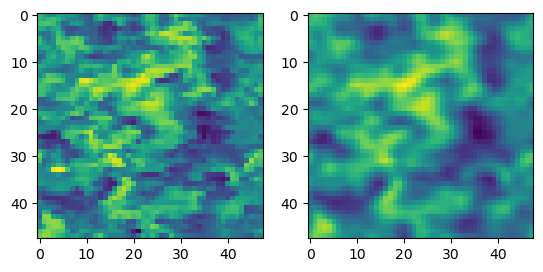

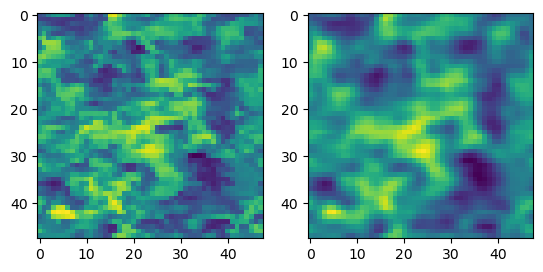

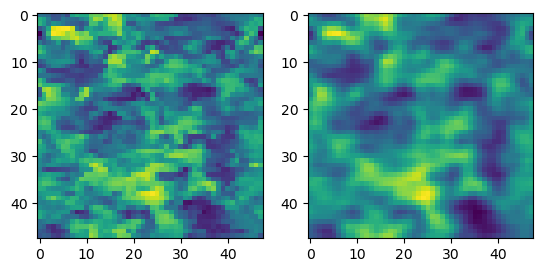

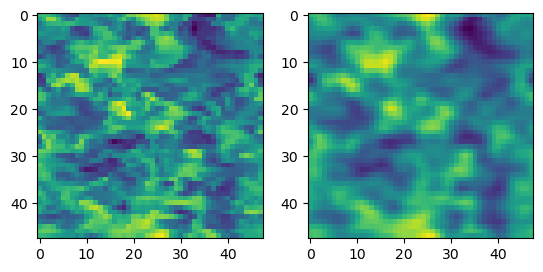

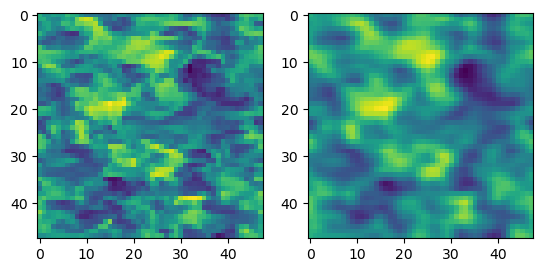

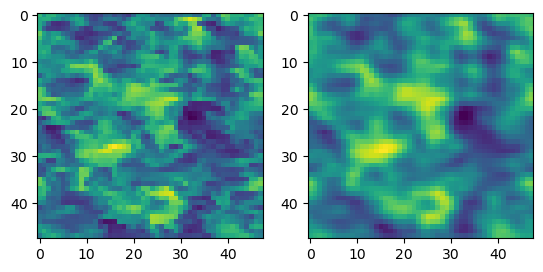

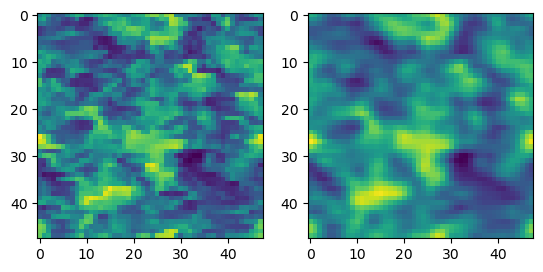

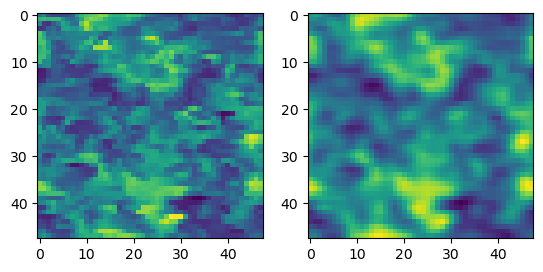

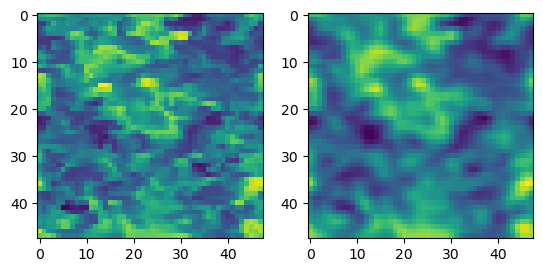

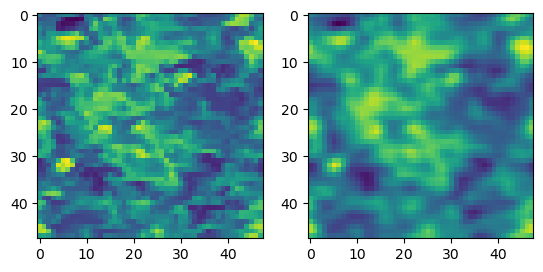

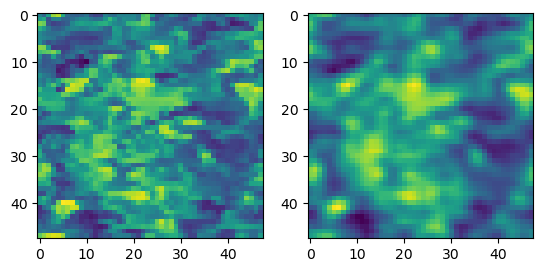

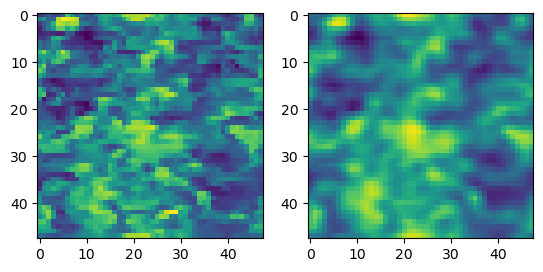

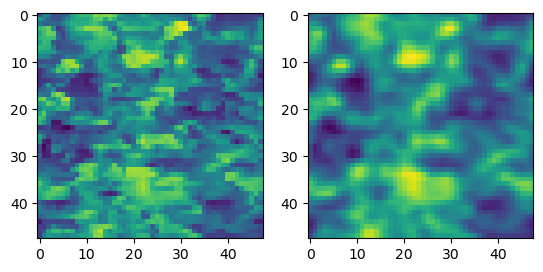

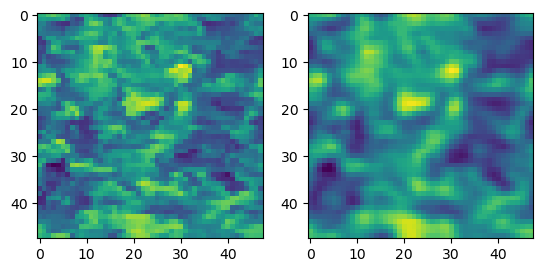

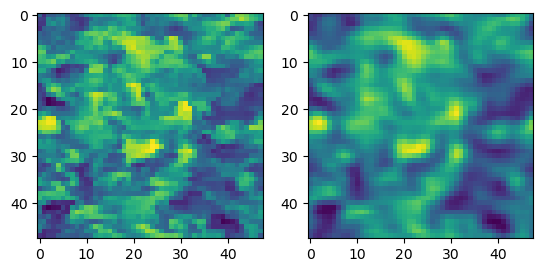

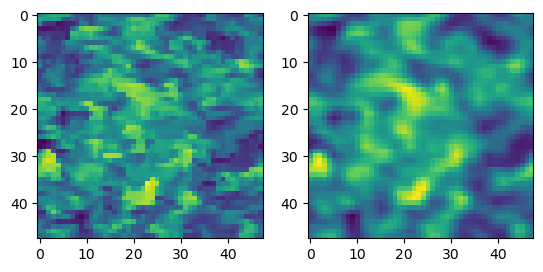

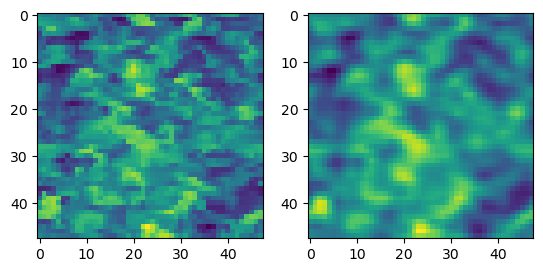

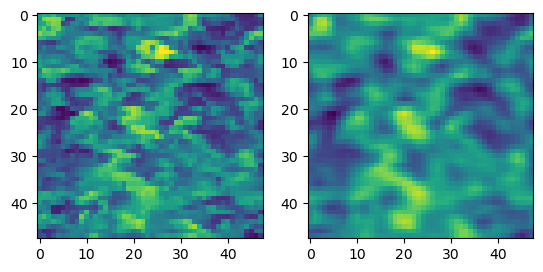

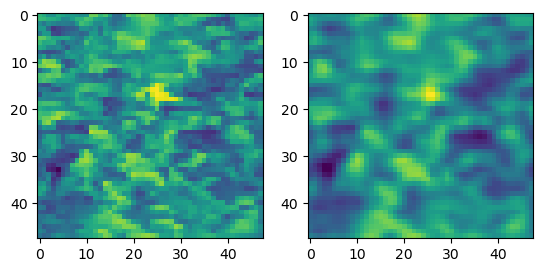

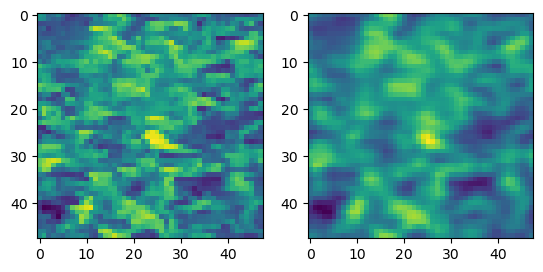

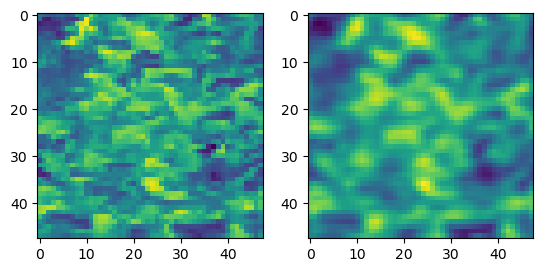

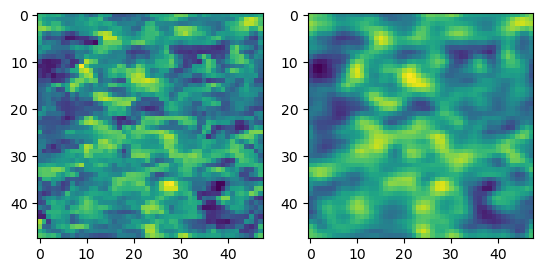

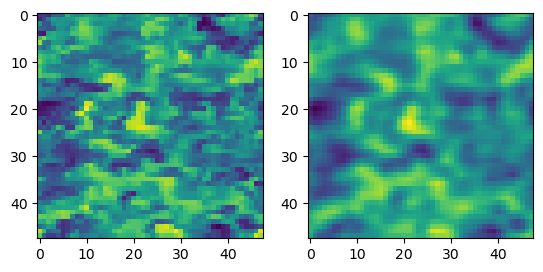

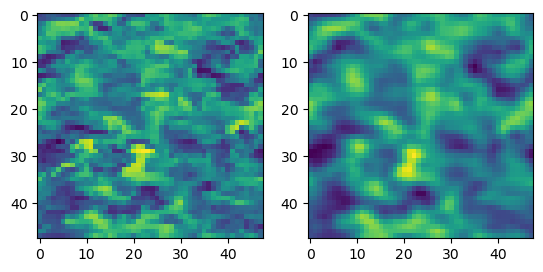

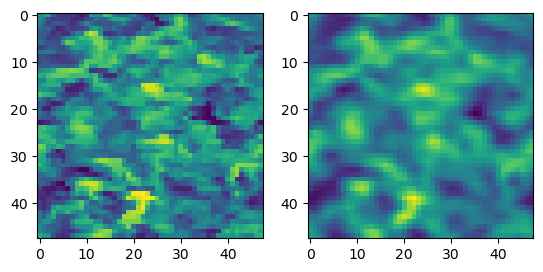

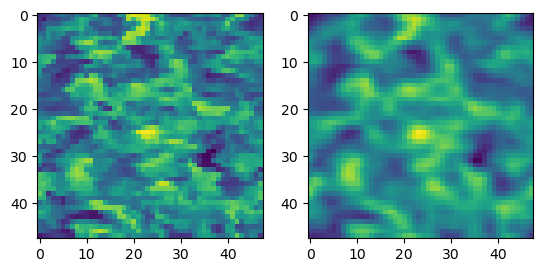

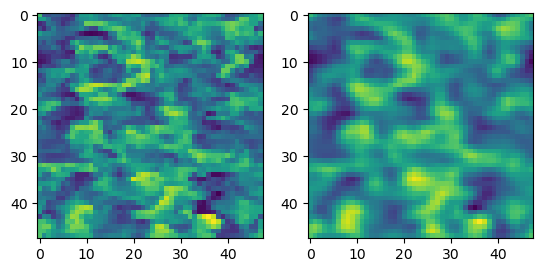

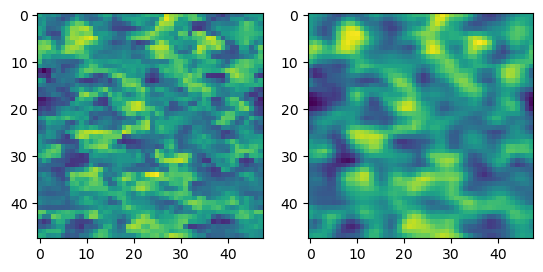

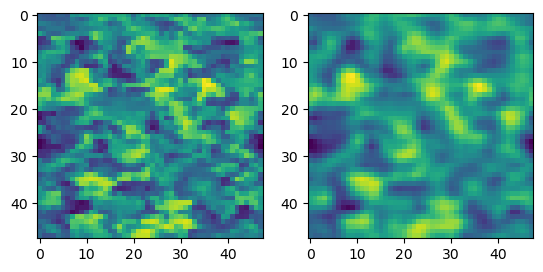

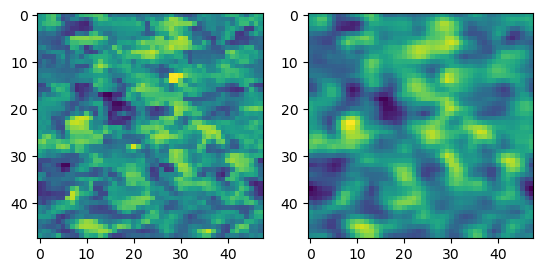

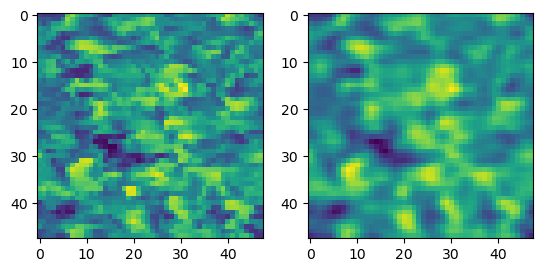

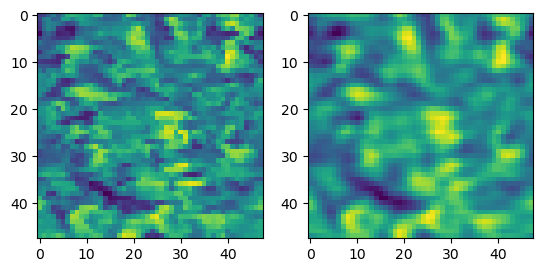

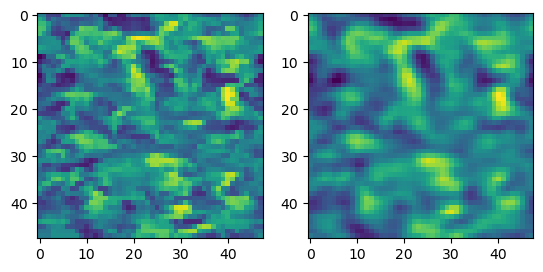

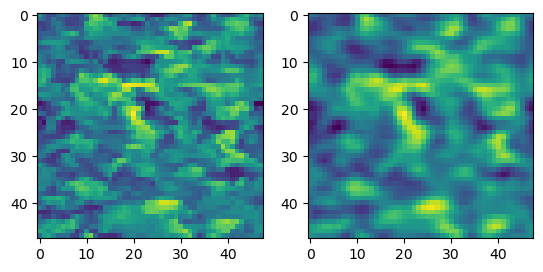

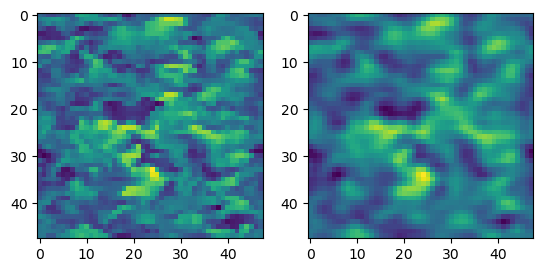

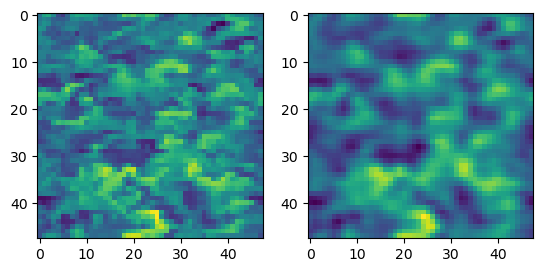

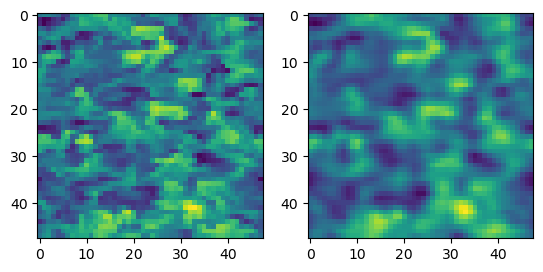

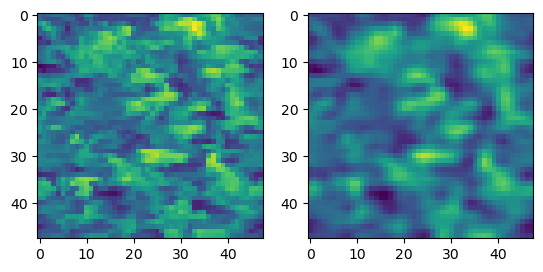

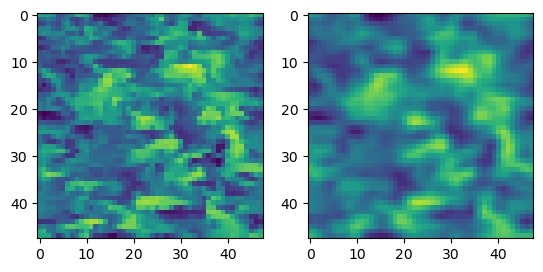

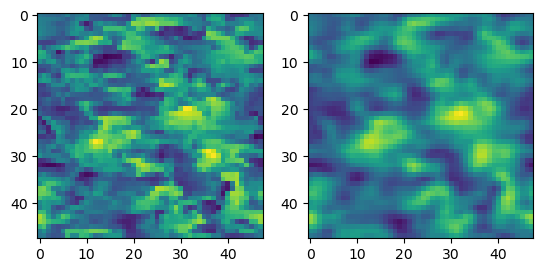

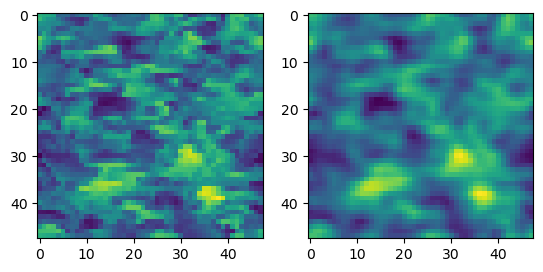

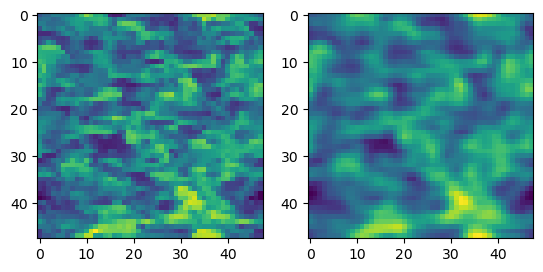

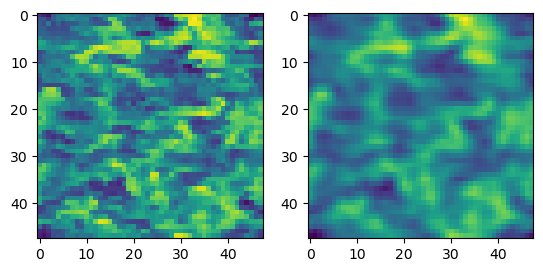

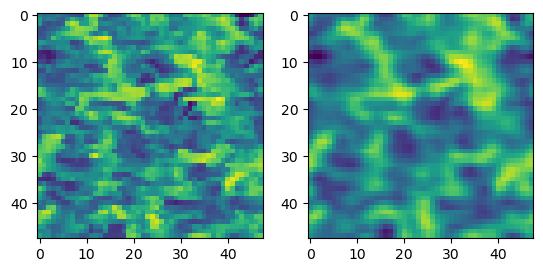

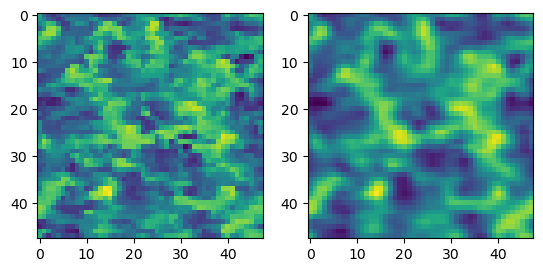

In [79]:
def other_visual_func():
    from utils.data_loading import normalize
    from utils.testing_utils import evaluate_on_whole_image
    from matplotlib import markers, pyplot as plt
    from scipy.interpolate import RegularGridInterpolator as RGI
    from glob import glob
    from utils.data_loading import read_p_thermo, middle_point
    from utils.blur import convolve_numpy
    from utils.utils import load_fortran_to_c
    import os
    import numpy as np
    import interp as tc
    import torch
    from glob import glob
    from utils.data_loading import read_p_thermo, middle_point
    from utils.blur import convolve_box_kernel_regular
    from utils.utils import load_fortran_to_c
    from utils.laplace import lap_recon_non_padded
    import os
    from datahandling import compute_rms, matplotlib_latex_params
    from scipy.interpolate import CubicSpline
    from datahandling import compute_rms
    import seaborn as sns
    from natsort import natsorted
    def dtdy(T, coord_les):
        k = np.arange(0, T.shape[-1] - 1)
        x, y, z = coord_les
        T_dns_on_les_field = T
        dtdy = np.zeros([*T_dns_on_les_field.shape[:-1], T_dns_on_les_field.shape[-1] + 1])
        dtdy[..., 1:-1] = (T[..., k+1] - T[..., k])/(z[k+1] - z[k])
        d1, d2 = z[1] - z[0], z[2] - z[0]
        d12 = z[2] - z[1]
        dtdy[..., 0] = - d1*d2/d12 * (T[..., 2] / (d2**2) - T[..., 1] / (d1**2) - T[..., 0] * ((d1**2 - d2**2)/((d1**2) * (d2**2))))
        dtdy[..., -1] =  d1*d2/d12 * (T[..., -3] / (d2**2) - T[..., -2] / (d1**2) - T[..., -1] * ((d1**2 - d2**2)/((d1**2) * (d2**2))))
        return dtdy
    def d2tdy2(T, dtdy, coord_les):
        x, y, z = coord_les
        k = np.arange(T.shape[-1])
        out = (dtdy[..., k+1] - dtdy[..., k])/(z[k+1] - z[k])
        return out
    ndns = (384, 384, 266)
    nles = (48, 48, 52)

    path = "/home/zatout/Documents/These_yanis/Reunion_10012022/dns_180/"
    path_coords = sorted(glob(path+"dns_lata_1.sauv.lata.grid_geom2.coord*"))
    path_p_thermo = sorted(glob(f"{path}/dns_lata_*.sauv"))
    p_thermo = [read_p_thermo(c) for c in path_p_thermo]
    path_rho = sorted(glob(path+"dns_lata_*.sauv.lata.0.RHO"))
    path_coord_les = "/home/zatout/Documents/These_yanis/Reunion_10012022/les_180/"
    coord_vertex = [np.fromfile(g, dtype=np.float32) for g in path_coords]
    coord = [middle_point(c) for c in coord_vertex]
    steps = [np.diff(c) for c in coord]
    steps = [torch.tensor(steps[0][0]), torch.tensor(steps[1][0]), steps[2]]
    def shape(x):
        return [xx.shape for xx in x]

    cs = CubicSpline(np.arange(ndns[-1]+1)/ndns[-1], coord_vertex[-1])
    coord_face_interp = cs(np.arange(nles[-1]+1)/nles[-1])
    coord_vertex_les = [
        np.linspace(coord_vertex[0].min(), coord_vertex[0].max(), nles[0]+1),
        np.linspace(coord_vertex[1].min(), coord_vertex[1].max(), nles[1]+1),
        coord_face_interp
    ]

    coord_les = [
        middle_point(c) for c in coord_vertex_les
    ]

    train_path = glob("/home/zatout/Documents/These_yanis/Reunion_10012022/dns_coarse_180/48_52_48/T*")
    train_les_path = glob("/home/zatout/Documents/These_yanis/Reunion_10012022/les_180/48_52_48/T*")
    coord_les = [
        middle_point(c) for c in coord_vertex_les
    ]
    coord_les_float64 = [
        c.astype("double") for c in coord_les
    ]
    steps_les = [
        np.diff(c) for c in coord_les
    ]
    steps_les = [*[s[1] for s in steps_les[:2]], steps_les[-1]]
    les_3 = np.meshgrid(*coord_les, indexing="ij")
    les_3 = np.concatenate([ss.ravel()[np.newaxis] for ss in les_3]).T
    dns_3 = np.meshgrid(*coord, indexing="ij")
    dns_3 = np.concatenate([ss.ravel()[np.newaxis] for ss in dns_3]).T
    coord_float64 = [c.astype("float64") for c in coord]

    """
    # Filtering part
    for p_th, rho_path in zip(p_thermo, path_rho):
        rho = load_fortran_to_c(rho_path, ndns)
        r_air = 287.058
        T_dns = p_th/(rho*r_air)
        T_dns = T_dns.numpy().astype(np.float64)
        # T_dns = np.ascontiguousarray(T_dns.reshape(*ndns, order="F")).reshape(-1)
        spline = tc.csp3d_open(*coord_float64, *ndns, T_dns)

        T_dns_on_les_field = tc.eval_all_spline_3d(
            les_3, *coord_float64, ndns, T_dns, spline).reshape(*nles)

        filter_size = 3
        filter_size_torch = torch.tensor(filter_size)
        T_filtered_LES = convolve_numpy(
            T_dns_on_les_field,
            filter_size=filter_size,
            coord_vertex=coord_vertex_les,
        )
        number = rho_path.split("dns_lata_")
        number = int(number[1].split(".sauv")[0])
        print(number)
        T_filtered_LES.tofile(path+"extra/coarse/"+f"T_coarse_{number}.npy")
    """

    """
    # Independent filtering
    for t, name in zip(other, natsorted(os.listdir(path+"extra/coarse"))):
        filtered = convolve_numpy(t, 3, coord_vertex_les)
        number = name.split(".npy")[0].split("T_coarse_")[1]
        filtered.tofile(path+"extra/les/"+f"T_les_{number}.npy")
    """
    path_rho = natsorted(glob(path+"extra/fine/"+"dns_lata_*.sauv.lata.0.RHO"))
    path_p_thermo = natsorted(glob(path+"extra/fine/"+"*.sauv"))
    p_thermo = [read_p_thermo(c) for c in path_p_thermo]

    other_path = natsorted(glob(path+"/extra/coarse/T*"))
    train_dns = np.array([np.fromfile(t).reshape(*nles) for t in train_path[:13]])
    other = np.array([np.fromfile(t).reshape(*nles) for t in other_path])
    other_filtered = np.array([np.fromfile(file_path).reshape(*nles) for file_path in natsorted(glob(path+"extra/les/48_52_48/T_*.npy"))])
    print(natsorted(glob(path+"extra/les/48_52_48/T_*.npy")))
    print(os.listdir(path+"extra/les/48_52_48"))
    print(other_filtered.shape)
    for o, of in zip(other, other_filtered):
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(o[..., 26])
        ax[1].imshow(of[..., 26])
other_visual_func()